<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 U-Net Semantic Segmentation

The following builds a U-Net for semantic segmentation. We will be using the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which contains 7,349 images of cats and dogs, along with their breed and segmentation mask.

## 2.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from datasets import load_from_disk, disable_caching, DatasetDict
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the datasets folder (should be in shared/datasets/oxford_pets)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'oxford_pets')

# Set the directory to the shared models folder (should be in shared/models/oxford_pets)
model_dir = os.path.join(path, '..', 'shared', 'models', 'oxford_pets')

## 2.1 Load and pre-process  data

Dataset Features: ['image', 'image_name', 'breed', 'dog', 'pose', 'bbox', 'seg_mask']
Number of training images = 2579
Number of validation images = 553
Number of test images = 553


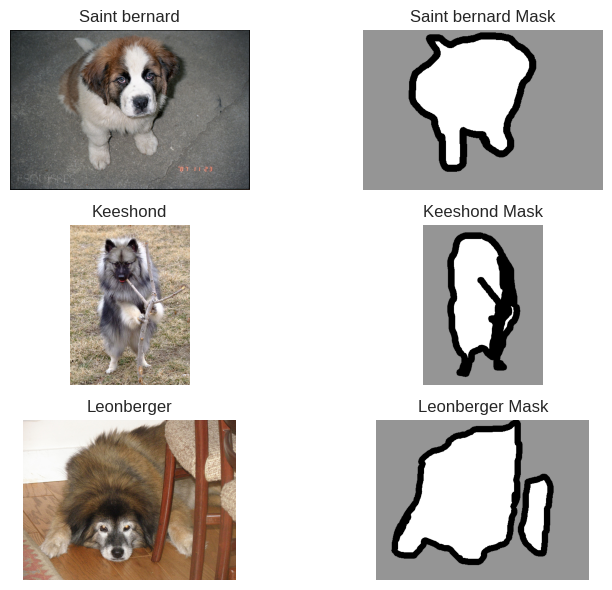

In [2]:
# Load the dataset (and disable caching)
disable_caching()
dataset = load_from_disk(datasets_dir)

# Split the dataset into train, validation and test
train_test = dataset.train_test_split(test_size=0.3, shuffle=True)
valid_test = train_test['test'].train_test_split(test_size=0.5, shuffle=True)
dataset = DatasetDict({'train': train_test['train'], 'valid': valid_test['train'], 'test': valid_test['test']})

print(f"Dataset Features: {list(dataset['train'].features.keys())}")
print(f"Number of training images = {dataset['train'].num_rows}")
print(f"Number of validation images = {dataset['valid'].num_rows}")
print(f"Number of test images = {dataset['test'].num_rows}")

# Display some random images
rand_index = np.random.choice(range(len(dataset['train'])), 3)
fig, ax = plt.subplots(len(rand_index), 2, figsize=(8, 6))
ax = ax.ravel()
im_ind = 0
for i in range(0, len(rand_index)*2, 2):

    # Get the example data
    example = dataset['train'][int(rand_index[im_ind])]

    # Get the label
    label = example['breed'].capitalize()

    # Display the image
    ax[i].imshow(example['image'])
    ax[i].set_title(label)
    ax[i].axis('off')

    # Display the segmentation mask
    ax[i+1].imshow(example['seg_mask'])
    ax[i+1].set_title(label + ' Mask')
    ax[i+1].axis('off')

    im_ind += 1
fig.tight_layout()
plt.show()

### Resize the images and segmentation mask

The images are currently various sizes and dimensions, so need to resize them into uniform dimensions. In this case 256 is appropriate.

However, when resizing the image we also need to resize the segmentation mask! This is much harder to do within a processing pipeline, because the mask is effectively the target label. So instead simply create a function to apply to the dataset.

Finally, convert the Hugging Face 🤗 dataset to Tensorflow.

In [3]:
# Set the image dimensions
image_dim = 256
batch_size = 32

# Function to resize the images and segmentation masks
def resize(examples):

    for i in range(len(examples['image'])):
        # Resize the image
        examples['image'][i] = examples['image'][i].convert("RGB").resize((image_dim, image_dim))

        # Resize the segmentation mask
        examples['seg_mask'][i] = examples['seg_mask'][i].resize((image_dim, image_dim))

    return examples

if not grading:
    # Apply the preprocessing function to the dataset
    dataset = dataset.map(resize, batched=True)

    # Convert to tf dataset
    train = dataset['train'].to_tf_dataset(columns=['image'], label_cols=['seg_mask'], batch_size=batch_size, shuffle=True)
    valid = dataset['valid'].to_tf_dataset(columns=['image'], label_cols=['seg_mask'], batch_size=batch_size, shuffle=False)
    test = dataset['test'].to_tf_dataset(columns=['image'], label_cols=['seg_mask'], batch_size=batch_size, shuffle=False)

Map:   0%|          | 0/2579 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

/opt/conda/lib/python3.11/site-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


## 2.2 U-Net

The following cells define a U-Net model. We define a number of filters which will be used in the downsampling and upsampling blocks.

The downsampling blocks are made up of standard convolutional and pooling layers, like a standard CNN. For each block we keep the output of the final convolutional layer to create the residual (skip) connection with the upsampling layers. These layers reduce the dimensionality of the image but identify important features.

The upsampling layers use transposed convolution layers, which increase the dimensionality of the feature maps back to the original dimensions. The residual connections help to localise the features within the upscaled image.

Finally the classification layer is a convolutional layer with the same number of filters as the segmentation map and a kernel size of 1. This produces per-pixel classification of the entire image. The segmentation masks contain 3 classes: 0 is pet, 1 is background and 2 is border.

In [4]:
# Input layer takes an image of shape=(image_dim, image_dim, 3)
inputs = layers.Input(shape=(image_dim, image_dim, 3), name='input')

# Rescale the input
x = layers.Rescaling(scale=1./255)(inputs)

# Set the number of filters for the convolutional layers
filters = [64, 128, 256, 512]
residuals = []

# Downsampling layers
for block_filters in filters:
    # Two convolutions followed by max pooling
    x = layers.Conv2D(block_filters, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
    x = layers.Conv2D(block_filters, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
    residuals.append(x)  # Keep the residual
    x = layers.MaxPooling2D(pool_size=2, padding="valid")(x)
    x = layers.Dropout(0.3)(x)

# Bottleneck layers
x = layers.Conv2D(filters[-1] * 2, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
x = layers.Conv2D(filters[-1] * 2, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.3)(x)

# Upsample layers
for block_filters in reversed(filters):
    # Transpose convolution
    x = layers.Conv2DTranspose(block_filters, kernel_size=2, strides=2, padding="same")(x)
    x = layers.concatenate([x, residuals.pop()])  # Add the residual
    x = layers.Dropout(0.3)(x)
    # Two convolutions
    x = layers.Conv2D(block_filters, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
    x = layers.Conv2D(block_filters, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)

# Output layer
outputs = layers.Conv2D(filters=3, kernel_size=1, padding="valid", activation="softmax", name='per-pixel_clsf')(x)

# Create intersection over union metric
seg_iou = tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False, name='iou')

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='segmentation_model')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[seg_iou])
model.summary()

Model: "segmentation_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#             os.path.join(data_dir, 'pets_segmentation_vgg.weights.h5'),
#             monitor='loss',
#             verbose=0,
#             save_best_only=True,
#             save_weights_only=True,
#             mode='min',
#             save_freq='epoch')

#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0.001,
#         patience=10,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(train, epochs=100, validation_data=valid, batch_size=batch_size, callbacks=[model_chkptr,model_earlystp], verbose=2)
#     # Save the results
#     with open(os.path.join(data_dir, 'pets_segmentation_vgg_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.197
Train seg iou: 0.639
Best validation loss: 0.310
Best validation seg iou: 0.713


/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


18/18 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - iou: 0.7752 - loss: 0.2218
Test loss: 0.222
Test seg iou: 0.775


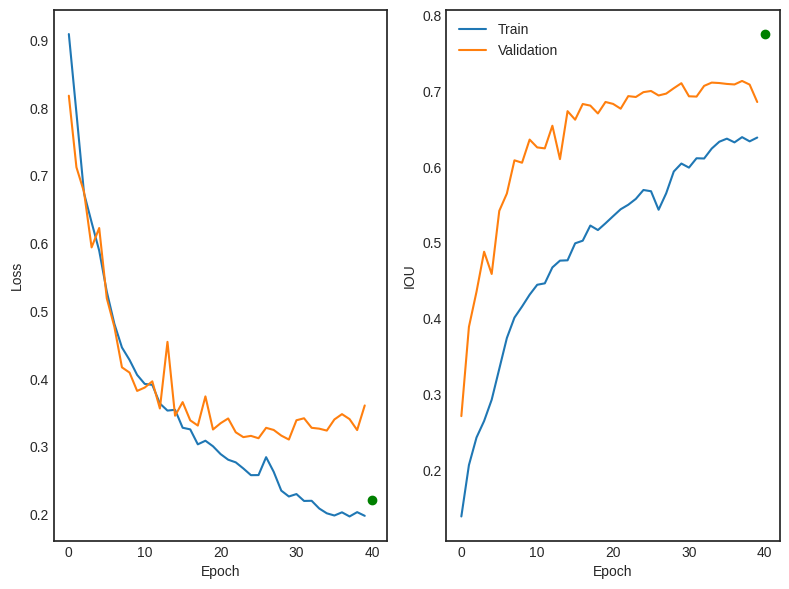

In [5]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'pets_segmentation_vgg_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:  
    # Or get them from model training
    metrics = results.history

print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train seg iou: {max(metrics['iou']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation seg iou: {max(metrics['val_iou']):.3f}")

# Evaluate on the test set
model.load_weights(os.path.join(model_dir, 'pets_segmentation_vgg.weights.h5'))
test_metrics = model.evaluate(test)
print(f"Test loss: {test_metrics[0]:.3f}")
print(f"Test seg iou: {test_metrics[1]:.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
ax = ax.flatten()
ax[0].plot(metrics['loss'], label='Train Loss')
ax[0].plot(metrics['val_loss'], label='Validation Loss')
ax[0].scatter(len(metrics['loss']), test_metrics[0], label='Test Loss', color='green')
ax[0].set(xlabel='Epoch', ylabel='Loss')

ax[1].plot(metrics['iou'], label='Train Segmentation IOU')
ax[1].plot(metrics['val_iou'], label='Validation Segmentation IOU')
ax[1].scatter(len(metrics['iou']), test_metrics[1], label='Test IoU', color='green')
ax[1].set(xlabel='Epoch', ylabel='IOU')

plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

### Qualitative evaluation of predicted segmentation masks

18/18 ━━━━━━━━━━━━━━━━━━━━ 315s 17s/step


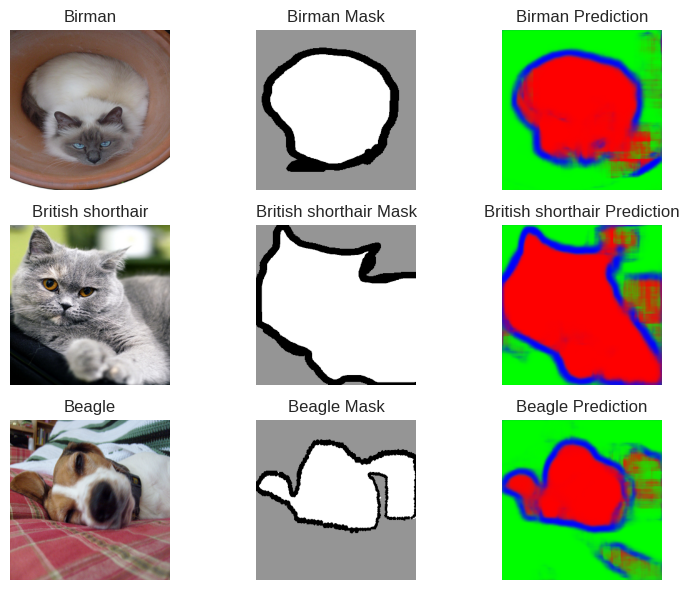

In [7]:
if not grading:
    # Generate some predictions
    predictions = model.predict(test)

    # Display some random images
    rand_index = np.random.choice(range(len(dataset['test'])), 3)

    fig, ax = plt.subplots(len(rand_index), 3, figsize=(8, 6))
    ax = ax.ravel()
    im_ind = 0
    for i in range(0, len(rand_index)*3, 3):

        # Get the example data
        example = dataset['test'][int(rand_index[im_ind])]
        
        # Get the label
        label = example['breed'].capitalize()
        
        # Display the image
        ax[i].imshow(example['image'])
        ax[i].set_title(label)
        ax[i].axis('off')

        # Display the segmentation mask
        ax[i+1].imshow(example['seg_mask'])
        ax[i+1].set_title(label + ' Mask')
        ax[i+1].axis('off')
        
        # Display the prediction
        ax[i+2].imshow(predictions[rand_index[im_ind]])
        ax[i+2].set_title(label + ' Prediction')
        ax[i+2].axis('off')

        im_ind += 1
    fig.tight_layout()
    plt.show()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280
